# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

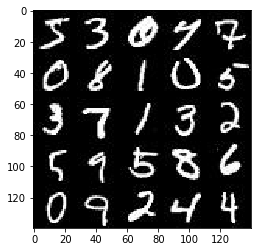

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

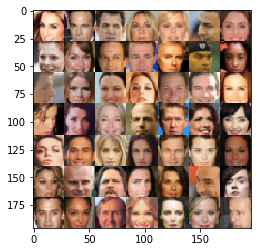

In [3]:
show_n_images = 49

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), \
    'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels])
    tensor_Z = tf.placeholder(tf.float32,[None,z_dim])
    learn_rate = tf.placeholder(tf.float32)
    return input_image, tensor_Z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.015
    batchSize,height_i,width_i,deepth_i = images.get_shape().as_list()
    kernal_size = 5
    stridesNum = 2
    with tf.variable_scope('discriminator',reuse=reuse):
        # Input layer is height_i x width_i x deepth_i
        Layer1 = tf.layers.conv2d(images, 64, kernal_size, strides=stridesNum, padding='same')
        relu1 = tf.maximum(alpha * Layer1, Layer1)
        # Now height_i-kernal_size x width_i/2 x 64
        #print(relu1.shape)
        
        Layer2 = tf.layers.conv2d(relu1, 128, kernal_size, strides=stridesNum, padding='same')
        bn2 = tf.layers.batch_normalization(Layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # height_i/4 x width_i/4 x 128
        #print(relu2.shape)
        
        Layer3 = tf.layers.conv2d(relu2, 256, kernal_size, strides=stridesNum, padding='same')
        bn3 = tf.layers.batch_normalization(Layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # height_i/8 x width_i/8 x 256
        #print(relu3.shape)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        #print(logits.shape)
        outputs = tf.sigmoid(logits)
    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        kernal_size = 5
        strideNum = 2
        alpha=0.01
        # First fully connected layer
        gLayer1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        gLayer1 = tf.reshape(gLayer1, (-1,7,7, 256))
        gLayer1 = tf.layers.batch_normalization(gLayer1, training=is_train)
        gLayer1 = tf.maximum(alpha * gLayer1, gLayer1)
        # 5x5x256 now
        #print(gLayer1.shape)        
        gLayer2 = tf.layers.conv2d_transpose(gLayer1, 128, kernal_size, strides=strideNum, padding='same')
        gLayer2 = tf.layers.batch_normalization(gLayer2, training=is_train)
        gLayer2 = tf.maximum(alpha * gLayer2, gLayer2)
        # 14x14x128 now
        #print(gLayer2.shape)        
        gLayer3 = tf.layers.conv2d_transpose(gLayer2, 64, kernal_size, strides=strideNum, padding='same')
        gLayer3 = tf.layers.batch_normalization(gLayer3, training=is_train)
        gLayer3 = tf.maximum(alpha * gLayer3, gLayer3)
        # 14x14x128 now
        #print(gLayer3.shape)        
        # Output layer
        g_logits = tf.layers.conv2d_transpose(gLayer3, out_channel_dim, kernal_size, strides=1, padding='same')
        # 28x28 x out_channel_dim now
        #print(g_logits.shape)        
        g_outputs = tf.tanh(g_logits)
    return g_outputs


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
import math
import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    step_count = 0
    
    input_real, input_z,l_rate = model_inputs(data_shape[2],data_shape[1],data_shape[3], z_dim)
    d_loss,g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt,g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    print_info_batch_cnt = 20
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        lastBatchesTime = time.time()
        for epoch_i in range(epoch_count):
            batch_cnt = 0
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                step_count += 1
                batch_cnt += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # TODO: Train Model
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,l_rate:learning_rate })
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,l_rate:learning_rate })
                
                if step_count % print_info_batch_cnt == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{}...".format(batch_cnt,math.ceil(data_shape[0]/batch_images.shape[0])),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    print("This {} batches takes:{:.4f} sec".format(print_info_batch_cnt,(time.time()-lastBatchesTime)))
                    lastBatchesTime = time.time()
                    
                if step_count % 200 == 0:
                    show_generator_output(sess,25,input_z,data_shape[3],data_image_mode)
        show_generator_output(sess,25,input_z,data_shape[3],data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 20/938... Discriminator Loss: 2.2460... Generator Loss: 4.9930
This 20 batches takes:12.9001 sec
Epoch 1/2... Batch 40/938... Discriminator Loss: 0.4084... Generator Loss: 3.9439
This 20 batches takes:12.4376 sec
Epoch 1/2... Batch 60/938... Discriminator Loss: 0.6628... Generator Loss: 2.1302
This 20 batches takes:12.3508 sec
Epoch 1/2... Batch 80/938... Discriminator Loss: 1.2547... Generator Loss: 1.4285
This 20 batches takes:12.3570 sec
Epoch 1/2... Batch 100/938... Discriminator Loss: 1.2494... Generator Loss: 1.1237
This 20 batches takes:12.3337 sec
Epoch 1/2... Batch 120/938... Discriminator Loss: 1.3410... Generator Loss: 0.6388
This 20 batches takes:12.3287 sec
Epoch 1/2... Batch 140/938... Discriminator Loss: 1.3205... Generator Loss: 0.6974
This 20 batches takes:12.2275 sec
Epoch 1/2... Batch 160/938... Discriminator Loss: 1.1589... Generator Loss: 0.9683
This 20 batches takes:12.2387 sec
Epoch 1/2... Batch 180/938... Discriminator Loss: 1.1894... Generato

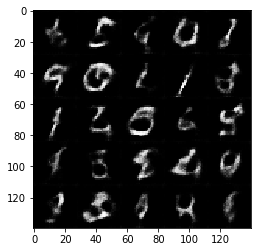

Epoch 1/2... Batch 220/938... Discriminator Loss: 1.3340... Generator Loss: 1.1911
This 20 batches takes:12.9962 sec
Epoch 1/2... Batch 240/938... Discriminator Loss: 1.5619... Generator Loss: 0.5029
This 20 batches takes:12.3983 sec
Epoch 1/2... Batch 260/938... Discriminator Loss: 1.2136... Generator Loss: 1.6179
This 20 batches takes:12.3602 sec
Epoch 1/2... Batch 280/938... Discriminator Loss: 1.2915... Generator Loss: 0.6988
This 20 batches takes:12.3993 sec
Epoch 1/2... Batch 300/938... Discriminator Loss: 1.2376... Generator Loss: 1.0365
This 20 batches takes:12.2327 sec
Epoch 1/2... Batch 320/938... Discriminator Loss: 1.2740... Generator Loss: 0.8963
This 20 batches takes:12.2667 sec
Epoch 1/2... Batch 340/938... Discriminator Loss: 1.2511... Generator Loss: 0.6314
This 20 batches takes:12.2857 sec
Epoch 1/2... Batch 360/938... Discriminator Loss: 1.2696... Generator Loss: 1.2249
This 20 batches takes:12.2427 sec
Epoch 1/2... Batch 380/938... Discriminator Loss: 1.2767... Gene

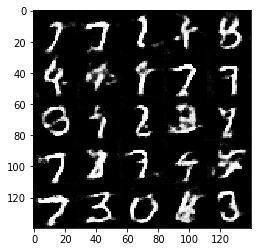

Epoch 1/2... Batch 420/938... Discriminator Loss: 1.0183... Generator Loss: 1.6317
This 20 batches takes:13.2632 sec
Epoch 1/2... Batch 440/938... Discriminator Loss: 1.3196... Generator Loss: 0.5647
This 20 batches takes:12.3687 sec
Epoch 1/2... Batch 460/938... Discriminator Loss: 1.3272... Generator Loss: 0.6083
This 20 batches takes:12.2867 sec
Epoch 1/2... Batch 480/938... Discriminator Loss: 1.1846... Generator Loss: 0.8191
This 20 batches takes:12.2317 sec
Epoch 1/2... Batch 500/938... Discriminator Loss: 1.0438... Generator Loss: 1.0045
This 20 batches takes:12.2437 sec
Epoch 1/2... Batch 520/938... Discriminator Loss: 1.1861... Generator Loss: 0.7556
This 20 batches takes:12.1846 sec
Epoch 1/2... Batch 540/938... Discriminator Loss: 1.2601... Generator Loss: 0.6801
This 20 batches takes:12.2337 sec
Epoch 1/2... Batch 560/938... Discriminator Loss: 1.0388... Generator Loss: 1.3865
This 20 batches takes:12.3141 sec
Epoch 1/2... Batch 580/938... Discriminator Loss: 1.0893... Gene

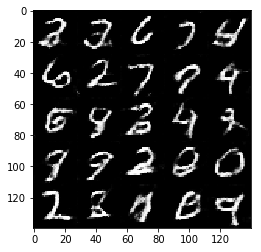

Epoch 1/2... Batch 620/938... Discriminator Loss: 0.9295... Generator Loss: 1.2751
This 20 batches takes:12.9972 sec
Epoch 1/2... Batch 640/938... Discriminator Loss: 1.4834... Generator Loss: 0.4641
This 20 batches takes:12.2098 sec
Epoch 1/2... Batch 660/938... Discriminator Loss: 1.2826... Generator Loss: 0.7203
This 20 batches takes:12.2146 sec
Epoch 1/2... Batch 680/938... Discriminator Loss: 1.1353... Generator Loss: 1.2480
This 20 batches takes:12.2036 sec
Epoch 1/2... Batch 700/938... Discriminator Loss: 1.2008... Generator Loss: 1.3708
This 20 batches takes:12.1766 sec
Epoch 1/2... Batch 720/938... Discriminator Loss: 1.2339... Generator Loss: 0.7523
This 20 batches takes:12.1893 sec
Epoch 1/2... Batch 740/938... Discriminator Loss: 0.9063... Generator Loss: 1.5459
This 20 batches takes:12.1796 sec
Epoch 1/2... Batch 760/938... Discriminator Loss: 1.2018... Generator Loss: 0.6973
This 20 batches takes:12.3199 sec
Epoch 1/2... Batch 780/938... Discriminator Loss: 1.5290... Gene

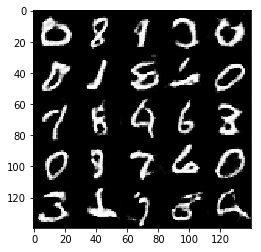

Epoch 1/2... Batch 820/938... Discriminator Loss: 1.0033... Generator Loss: 1.7199
This 20 batches takes:12.8475 sec
Epoch 1/2... Batch 840/938... Discriminator Loss: 0.9533... Generator Loss: 1.1018
This 20 batches takes:12.1813 sec
Epoch 1/2... Batch 860/938... Discriminator Loss: 1.3779... Generator Loss: 0.5883
This 20 batches takes:12.2517 sec
Epoch 1/2... Batch 880/938... Discriminator Loss: 1.0669... Generator Loss: 0.9432
This 20 batches takes:12.3383 sec
Epoch 1/2... Batch 900/938... Discriminator Loss: 1.2064... Generator Loss: 0.6883
This 20 batches takes:12.2487 sec
Epoch 1/2... Batch 920/938... Discriminator Loss: 1.1108... Generator Loss: 0.7853
This 20 batches takes:12.1686 sec
Epoch 2/2... Batch 3/938... Discriminator Loss: 0.9748... Generator Loss: 1.2407
This 20 batches takes:12.1806 sec
Epoch 2/2... Batch 23/938... Discriminator Loss: 1.2532... Generator Loss: 0.6827
This 20 batches takes:12.1646 sec
Epoch 2/2... Batch 43/938... Discriminator Loss: 1.0878... Generato

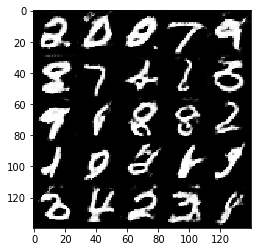

Epoch 2/2... Batch 83/938... Discriminator Loss: 0.8561... Generator Loss: 1.2062
This 20 batches takes:12.9752 sec
Epoch 2/2... Batch 103/938... Discriminator Loss: 1.2237... Generator Loss: 0.9630
This 20 batches takes:12.2116 sec
Epoch 2/2... Batch 123/938... Discriminator Loss: 0.8972... Generator Loss: 1.3174
This 20 batches takes:12.1774 sec
Epoch 2/2... Batch 143/938... Discriminator Loss: 1.4012... Generator Loss: 0.5584
This 20 batches takes:12.1784 sec
Epoch 2/2... Batch 163/938... Discriminator Loss: 1.0594... Generator Loss: 0.8023
This 20 batches takes:12.1689 sec
Epoch 2/2... Batch 183/938... Discriminator Loss: 0.9656... Generator Loss: 1.0267
This 20 batches takes:12.1819 sec
Epoch 2/2... Batch 203/938... Discriminator Loss: 0.8834... Generator Loss: 1.1383
This 20 batches takes:12.1486 sec
Epoch 2/2... Batch 223/938... Discriminator Loss: 0.8560... Generator Loss: 1.4493
This 20 batches takes:12.1656 sec
Epoch 2/2... Batch 243/938... Discriminator Loss: 0.9370... Gener

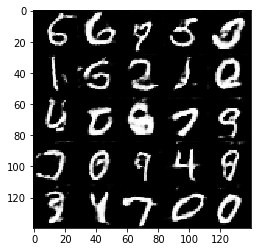

Epoch 2/2... Batch 283/938... Discriminator Loss: 0.9805... Generator Loss: 1.4112
This 20 batches takes:13.1143 sec
Epoch 2/2... Batch 303/938... Discriminator Loss: 1.4822... Generator Loss: 0.5664
This 20 batches takes:12.1430 sec
Epoch 2/2... Batch 323/938... Discriminator Loss: 1.1184... Generator Loss: 0.8193
This 20 batches takes:12.6680 sec
Epoch 2/2... Batch 343/938... Discriminator Loss: 1.1897... Generator Loss: 0.7033
This 20 batches takes:12.2792 sec
Epoch 2/2... Batch 363/938... Discriminator Loss: 1.0952... Generator Loss: 2.0198
This 20 batches takes:12.1456 sec
Epoch 2/2... Batch 383/938... Discriminator Loss: 1.1599... Generator Loss: 1.1267
This 20 batches takes:12.1896 sec
Epoch 2/2... Batch 403/938... Discriminator Loss: 0.8701... Generator Loss: 1.5138
This 20 batches takes:12.1386 sec
Epoch 2/2... Batch 423/938... Discriminator Loss: 1.1698... Generator Loss: 1.7209
This 20 batches takes:12.1246 sec
Epoch 2/2... Batch 443/938... Discriminator Loss: 1.0567... Gene

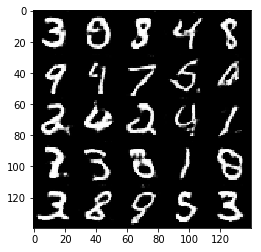

Epoch 2/2... Batch 483/938... Discriminator Loss: 0.9854... Generator Loss: 1.4547
This 20 batches takes:12.7560 sec
Epoch 2/2... Batch 503/938... Discriminator Loss: 0.7980... Generator Loss: 1.5155
This 20 batches takes:12.1276 sec
Epoch 2/2... Batch 523/938... Discriminator Loss: 0.9988... Generator Loss: 1.5784
This 20 batches takes:12.1196 sec
Epoch 2/2... Batch 543/938... Discriminator Loss: 0.9079... Generator Loss: 1.1386
This 20 batches takes:12.1056 sec
Epoch 2/2... Batch 563/938... Discriminator Loss: 0.7485... Generator Loss: 1.6468
This 20 batches takes:12.1456 sec
Epoch 2/2... Batch 583/938... Discriminator Loss: 1.0080... Generator Loss: 0.9580
This 20 batches takes:12.1096 sec
Epoch 2/2... Batch 603/938... Discriminator Loss: 0.8274... Generator Loss: 1.6021
This 20 batches takes:12.1156 sec
Epoch 2/2... Batch 623/938... Discriminator Loss: 0.7610... Generator Loss: 2.2380
This 20 batches takes:12.1436 sec
Epoch 2/2... Batch 643/938... Discriminator Loss: 0.8226... Gene

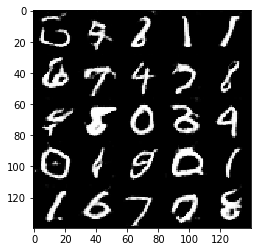

Epoch 2/2... Batch 683/938... Discriminator Loss: 1.0208... Generator Loss: 0.9119
This 20 batches takes:12.8751 sec
Epoch 2/2... Batch 703/938... Discriminator Loss: 1.0374... Generator Loss: 0.9719
This 20 batches takes:12.1176 sec
Epoch 2/2... Batch 723/938... Discriminator Loss: 0.7155... Generator Loss: 1.6197
This 20 batches takes:12.1096 sec
Epoch 2/2... Batch 743/938... Discriminator Loss: 0.7749... Generator Loss: 1.6109
This 20 batches takes:12.1016 sec
Epoch 2/2... Batch 763/938... Discriminator Loss: 1.2334... Generator Loss: 0.6534
This 20 batches takes:12.1016 sec
Epoch 2/2... Batch 783/938... Discriminator Loss: 1.4583... Generator Loss: 0.5088
This 20 batches takes:12.1316 sec
Epoch 2/2... Batch 803/938... Discriminator Loss: 0.8299... Generator Loss: 1.2545
This 20 batches takes:12.1206 sec
Epoch 2/2... Batch 823/938... Discriminator Loss: 0.8006... Generator Loss: 2.2252
This 20 batches takes:12.1096 sec
Epoch 2/2... Batch 843/938... Discriminator Loss: 0.8448... Gene

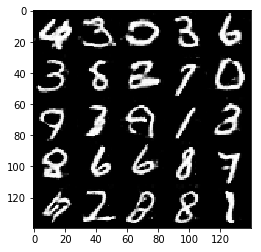

Epoch 2/2... Batch 883/938... Discriminator Loss: 1.1038... Generator Loss: 0.7970
This 20 batches takes:12.8121 sec
Epoch 2/2... Batch 903/938... Discriminator Loss: 1.0655... Generator Loss: 0.9075
This 20 batches takes:12.1436 sec
Epoch 2/2... Batch 923/938... Discriminator Loss: 0.8261... Generator Loss: 1.5189
This 20 batches takes:12.1777 sec


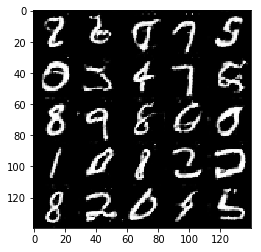

In [22]:
batch_size = 64
z_dim = 128
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 20/1583... Discriminator Loss: 0.5126... Generator Loss: 2.9967
This 20 batches takes:26.0765 sec
Epoch 1/1... Batch 40/1583... Discriminator Loss: 0.3515... Generator Loss: 4.7008
This 20 batches takes:25.5361 sec
Epoch 1/1... Batch 60/1583... Discriminator Loss: 0.8273... Generator Loss: 2.4695
This 20 batches takes:25.4981 sec
Epoch 1/1... Batch 80/1583... Discriminator Loss: 0.5674... Generator Loss: 2.7479
This 20 batches takes:25.6402 sec
Epoch 1/1... Batch 100/1583... Discriminator Loss: 0.4352... Generator Loss: 2.8611
This 20 batches takes:25.5386 sec
Epoch 1/1... Batch 120/1583... Discriminator Loss: 1.1269... Generator Loss: 4.0524
This 20 batches takes:25.5241 sec
Epoch 1/1... Batch 140/1583... Discriminator Loss: 0.6480... Generator Loss: 1.9234
This 20 batches takes:25.4700 sec
Epoch 1/1... Batch 160/1583... Discriminator Loss: 1.0896... Generator Loss: 0.7484
This 20 batches takes:25.5041 sec
Epoch 1/1... Batch 180/1583... Discriminator Loss: 1.3296...

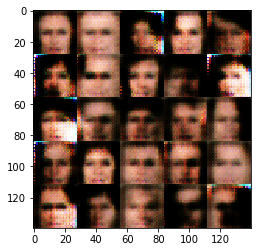

Epoch 1/1... Batch 220/1583... Discriminator Loss: 1.1782... Generator Loss: 1.1686
This 20 batches takes:26.0364 sec
Epoch 1/1... Batch 240/1583... Discriminator Loss: 1.7406... Generator Loss: 0.3676
This 20 batches takes:25.5541 sec
Epoch 1/1... Batch 260/1583... Discriminator Loss: 1.1027... Generator Loss: 2.1134
This 20 batches takes:25.4420 sec
Epoch 1/1... Batch 280/1583... Discriminator Loss: 1.2211... Generator Loss: 0.8367
This 20 batches takes:25.5041 sec
Epoch 1/1... Batch 300/1583... Discriminator Loss: 1.2103... Generator Loss: 1.8851
This 20 batches takes:25.5191 sec
Epoch 1/1... Batch 320/1583... Discriminator Loss: 1.0837... Generator Loss: 0.7835
This 20 batches takes:25.4330 sec
Epoch 1/1... Batch 340/1583... Discriminator Loss: 1.1462... Generator Loss: 1.6504
This 20 batches takes:25.5541 sec
Epoch 1/1... Batch 360/1583... Discriminator Loss: 0.5290... Generator Loss: 1.9065
This 20 batches takes:25.5681 sec
Epoch 1/1... Batch 380/1583... Discriminator Loss: 1.108

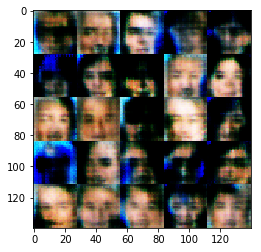

Epoch 1/1... Batch 420/1583... Discriminator Loss: 3.2378... Generator Loss: 0.1013
This 20 batches takes:42.5834 sec
Epoch 1/1... Batch 440/1583... Discriminator Loss: 0.7439... Generator Loss: 1.3362
This 20 batches takes:40.4829 sec
Epoch 1/1... Batch 460/1583... Discriminator Loss: 0.9478... Generator Loss: 1.0739
This 20 batches takes:43.1788 sec
Epoch 1/1... Batch 480/1583... Discriminator Loss: 0.5291... Generator Loss: 1.8332
This 20 batches takes:42.9507 sec
Epoch 1/1... Batch 500/1583... Discriminator Loss: 1.4725... Generator Loss: 0.5073
This 20 batches takes:40.4649 sec
Epoch 1/1... Batch 520/1583... Discriminator Loss: 1.9289... Generator Loss: 0.3034
This 20 batches takes:43.8764 sec
Epoch 1/1... Batch 540/1583... Discriminator Loss: 1.2703... Generator Loss: 0.7879
This 20 batches takes:42.7384 sec
Epoch 1/1... Batch 560/1583... Discriminator Loss: 1.0460... Generator Loss: 1.7232
This 20 batches takes:42.1760 sec
Epoch 1/1... Batch 580/1583... Discriminator Loss: 0.719

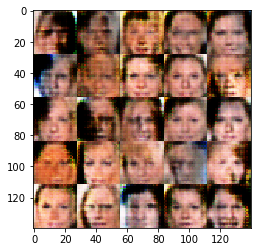

Epoch 1/1... Batch 620/1583... Discriminator Loss: 0.9095... Generator Loss: 0.9062
This 20 batches takes:45.0341 sec
Epoch 1/1... Batch 640/1583... Discriminator Loss: 1.0062... Generator Loss: 0.8562
This 20 batches takes:41.0313 sec
Epoch 1/1... Batch 660/1583... Discriminator Loss: 1.5570... Generator Loss: 0.6198
This 20 batches takes:39.2839 sec
Epoch 1/1... Batch 680/1583... Discriminator Loss: 0.8853... Generator Loss: 1.5282
This 20 batches takes:43.8693 sec
Epoch 1/1... Batch 700/1583... Discriminator Loss: 1.2706... Generator Loss: 0.8110
This 20 batches takes:40.9422 sec
Epoch 1/1... Batch 720/1583... Discriminator Loss: 1.3033... Generator Loss: 0.8162
This 20 batches takes:43.7319 sec
Epoch 1/1... Batch 740/1583... Discriminator Loss: 1.7878... Generator Loss: 0.3618
This 20 batches takes:39.9364 sec
Epoch 1/1... Batch 760/1583... Discriminator Loss: 1.2184... Generator Loss: 0.7577
This 20 batches takes:40.4758 sec
Epoch 1/1... Batch 780/1583... Discriminator Loss: 1.186

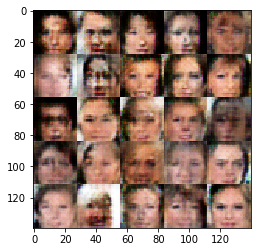

Epoch 1/1... Batch 820/1583... Discriminator Loss: 1.1276... Generator Loss: 0.9030
This 20 batches takes:47.4549 sec
Epoch 1/1... Batch 840/1583... Discriminator Loss: 0.7864... Generator Loss: 1.1648
This 20 batches takes:39.6182 sec
Epoch 1/1... Batch 860/1583... Discriminator Loss: 1.3964... Generator Loss: 0.4934
This 20 batches takes:39.7403 sec
Epoch 1/1... Batch 880/1583... Discriminator Loss: 1.1266... Generator Loss: 0.8005
This 20 batches takes:39.9084 sec
Epoch 1/1... Batch 900/1583... Discriminator Loss: 1.1833... Generator Loss: 1.0473
This 20 batches takes:40.8481 sec
Epoch 1/1... Batch 920/1583... Discriminator Loss: 1.0528... Generator Loss: 0.8936
This 20 batches takes:45.4448 sec
Epoch 1/1... Batch 940/1583... Discriminator Loss: 1.2699... Generator Loss: 0.5506
This 20 batches takes:43.2469 sec
Epoch 1/1... Batch 960/1583... Discriminator Loss: 0.9855... Generator Loss: 1.1305
This 20 batches takes:42.0020 sec
Epoch 1/1... Batch 980/1583... Discriminator Loss: 1.863

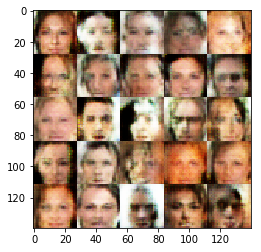

Epoch 1/1... Batch 1020/1583... Discriminator Loss: 1.3734... Generator Loss: 0.5424
This 20 batches takes:41.9139 sec
Epoch 1/1... Batch 1040/1583... Discriminator Loss: 1.4029... Generator Loss: 0.7522
This 20 batches takes:44.4319 sec
Epoch 1/1... Batch 1060/1583... Discriminator Loss: 1.1329... Generator Loss: 1.4538
This 20 batches takes:40.9201 sec
Epoch 1/1... Batch 1080/1583... Discriminator Loss: 1.3374... Generator Loss: 0.6765
This 20 batches takes:42.5141 sec
Epoch 1/1... Batch 1100/1583... Discriminator Loss: 1.1653... Generator Loss: 0.8031
This 20 batches takes:45.4861 sec
Epoch 1/1... Batch 1120/1583... Discriminator Loss: 1.4196... Generator Loss: 0.6379
This 20 batches takes:41.6472 sec
Epoch 1/1... Batch 1140/1583... Discriminator Loss: 1.2210... Generator Loss: 1.1946
This 20 batches takes:42.4614 sec
Epoch 1/1... Batch 1160/1583... Discriminator Loss: 1.2736... Generator Loss: 1.3040
This 20 batches takes:41.5068 sec
Epoch 1/1... Batch 1180/1583... Discriminator Lo

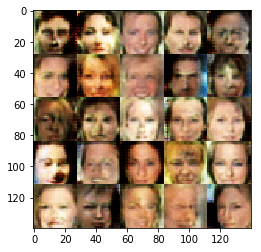

Epoch 1/1... Batch 1220/1583... Discriminator Loss: 1.3742... Generator Loss: 0.7695
This 20 batches takes:44.2938 sec
Epoch 1/1... Batch 1240/1583... Discriminator Loss: 1.3301... Generator Loss: 0.6418
This 20 batches takes:43.0526 sec
Epoch 1/1... Batch 1260/1583... Discriminator Loss: 1.2827... Generator Loss: 0.6954
This 20 batches takes:43.8127 sec
Epoch 1/1... Batch 1280/1583... Discriminator Loss: 1.3217... Generator Loss: 1.5761
This 20 batches takes:44.1208 sec
Epoch 1/1... Batch 1300/1583... Discriminator Loss: 1.4555... Generator Loss: 0.7649
This 20 batches takes:42.4014 sec
Epoch 1/1... Batch 1320/1583... Discriminator Loss: 1.2033... Generator Loss: 1.1729
This 20 batches takes:44.6440 sec
Epoch 1/1... Batch 1340/1583... Discriminator Loss: 1.3127... Generator Loss: 0.8755
This 20 batches takes:44.1893 sec
Epoch 1/1... Batch 1360/1583... Discriminator Loss: 1.0546... Generator Loss: 0.9565
This 20 batches takes:44.8049 sec
Epoch 1/1... Batch 1380/1583... Discriminator Lo

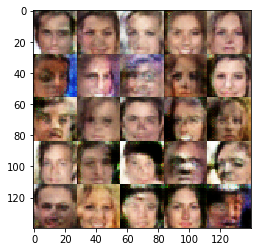

Epoch 1/1... Batch 1420/1583... Discriminator Loss: 1.1496... Generator Loss: 1.1475
This 20 batches takes:44.7954 sec
Epoch 1/1... Batch 1440/1583... Discriminator Loss: 1.1802... Generator Loss: 0.7944
This 20 batches takes:43.7046 sec
Epoch 1/1... Batch 1460/1583... Discriminator Loss: 1.1412... Generator Loss: 0.8624
This 20 batches takes:43.0728 sec
Epoch 1/1... Batch 1480/1583... Discriminator Loss: 1.3527... Generator Loss: 1.1269
This 20 batches takes:44.4176 sec
Epoch 1/1... Batch 1500/1583... Discriminator Loss: 1.3565... Generator Loss: 1.3299
This 20 batches takes:43.7059 sec
Epoch 1/1... Batch 1520/1583... Discriminator Loss: 1.2296... Generator Loss: 0.6782
This 20 batches takes:42.8598 sec
Epoch 1/1... Batch 1540/1583... Discriminator Loss: 1.1531... Generator Loss: 1.0924
This 20 batches takes:41.1028 sec
Epoch 1/1... Batch 1560/1583... Discriminator Loss: 1.9574... Generator Loss: 0.5025
This 20 batches takes:41.2512 sec
Epoch 1/1... Batch 1580/1583... Discriminator Lo

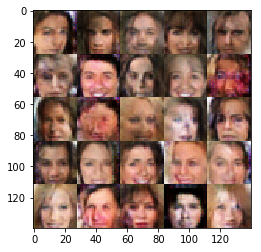

In [23]:
batch_size = 128
z_dim = 256
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.